Загрузка библиотек

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import v2
from torchvision import datasets, models
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!unzip '/content/drive/MyDrive/yellow/journey-springfield.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pi

Загрузка и обработка данных

In [ ]:
transform_train = v2.Compose([
    v2.Resize((640, 640), antialias=True),
    v2.ColorJitter(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float, scale=True),
])
transform_val = v2.Compose([
    v2.Resize((640, 640), antialias=True),
    v2.ToImage(),
    v2.ToDtype(torch.float, scale=True),
])

train_dataset = Dataset(dataframe=df_train, path='simpson/images_train', transform=transform_train)
valid_dataset = Dataset(dataframe=df_val, path='simpson/images_val', transform=transform_val)

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_valid = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 20933
    Root location: train/simpsons_dataset/
    StandardTransform
Transform: Compose(
                 Resize(size=[128, 128], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

In [ ]:
y = np.array([i[1] for i in data])

Разделение на тренировочную и тестовую выборку

In [ ]:
train_data, test_data = train_test_split(np.arange(len(data)), test_size=0.25, stratify=y, random_state=42)
train_data

array([15895, 14197,  3968, ...,  9963, 19807,  3183])

In [ ]:
train_data = Subset(data, train_data)
test_data = Subset(data, test_data)
test_data

используем GPU если можна

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Проверка на дисбаланс

In [ ]:
statistics = Counter(y)

<BarContainer object of 42 artists>

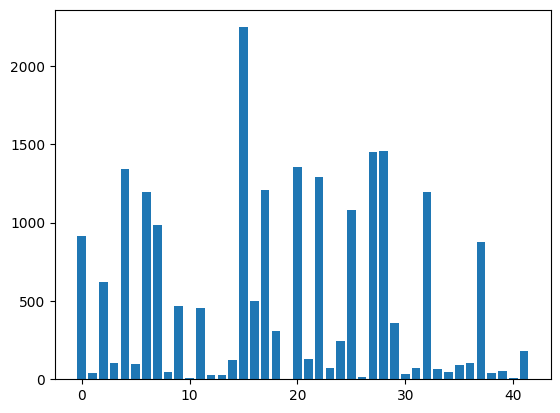

In [ ]:
plt.bar(statistics.keys(), statistics.values())

Делаем веса для классов, потому что дисбаланс

In [ ]:
weight = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight = torch.tensor(weight).to(torch.float).to(device)
weight

tensor([  0.5459,  11.8668,   0.8000,   4.7019,   0.3714,   5.0858,   0.4178,
          0.5055,  10.6044,   1.0627,  62.3006,   1.0906,  18.4594,  18.4594,
          4.1190,   0.2219,   1.0008,   0.4133,   1.6078, 166.1349,   0.3681,
          3.8938,   0.3861,   7.0198,   2.0260,   0.4619,  29.3179,   0.3433,
          0.3428,   1.3922,  15.5751,   6.9223,   0.4174,   7.6678,  11.0757,
          5.6001,   4.8389,   0.5683,  12.4601,   9.0619,  62.3006,   2.7536],
       device='cuda:0')

Подготовка данных для обучения

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 128, 128])
Shape of y: torch.Size([64]) torch.int64


Создание сверточной нейросети

In [ ]:
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(in_features=512, out_features=42, bias=True)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Создаем тренировачную функцию

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Создаем тестовую функцию

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    accuracy /= size
    print(f"Test Error: \n Accuracy: {(100 * accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return [accuracy, test_loss]

Обучение модели

In [25]:
loss_fn = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 50
m = [0] * epochs
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    m[t] = test(train_dataloader, model, loss_fn) + test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.000355  [   64/15699]
loss: 1.735900  [ 6464/15699]
loss: 1.057889  [12864/15699]
Test Error: 
 Accuracy: 68.0%, Avg loss: 0.819496 

Test Error: 
 Accuracy: 64.5%, Avg loss: 1.725460 

Epoch 2
-------------------------------
loss: 0.960748  [   64/15699]
loss: 0.274038  [ 6464/15699]
loss: 0.075707  [12864/15699]
Test Error: 
 Accuracy: 94.5%, Avg loss: 0.170999 

Test Error: 
 Accuracy: 87.6%, Avg loss: 1.076048 

Epoch 3
-------------------------------
loss: 0.088407  [   64/15699]
loss: 0.096190  [ 6464/15699]
loss: 0.034049  [12864/15699]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.035173 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.875578 

Epoch 4
-------------------------------
loss: 0.022839  [   64/15699]
loss: 0.022521  [ 6464/15699]
loss: 0.002902  [12864/15699]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.010889 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.866792 

Epoch 5
-------------------------------
loss: 0.004281  [   64/1

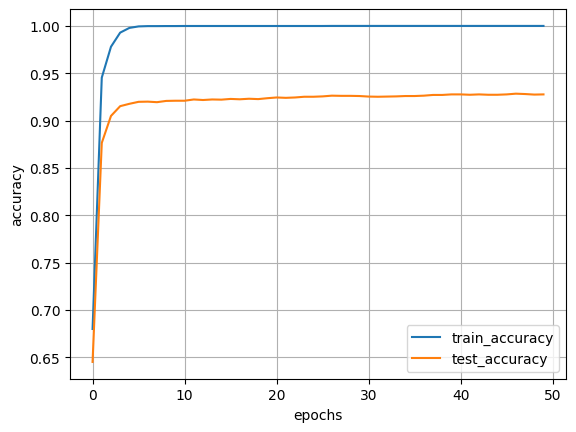

In [27]:
m = np.array(m)
plt.plot(m[:, ::2], label=['train_accuracy', 'test_accuracy'])
plt.grid()
plt.legend()
plt.xlabel("epochs")
plt.ylabel('accuracy')
plt.show()

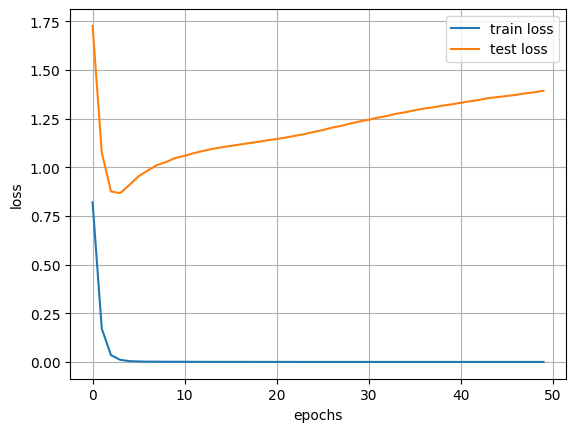

In [28]:
plt.plot(m[:, 1::2], label=['train loss', 'test loss'])
plt.grid()
plt.legend()
plt.xlabel("epochs")
plt.ylabel('loss')
plt.show()

Получаем названия классов

In [29]:
path = 'train/simpsons_dataset/'
classes = np.array(sorted([i for i in os.listdir(path) if os.path.isdir(os.path.join(path, i))]))
classes

array(['abraham_grampa_simpson', 'agnes_skinner',
       'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
       'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum',
       'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel',
       'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson',
       'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
       'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson',
       'martin_prince', 'mayor_quimby', 'milhouse_van_houten',
       'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz',
       'otto_mann', 'patty_bouvier', 'principal_skinner',
       'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum',
       'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird',
       'troy_mcclure', 'waylon_smithers'], dtype='<U24')

Предсказываем

In [30]:
path = 'testset/'
pred_data = datasets.ImageFolder(path, transform=transform)
pred_dataloader = DataLoader(pred_data, batch_size=1)
model.eval()
with torch.no_grad():
    y_pred = [''] * len(pred_dataloader)
    for i, (X, y) in enumerate(pred_dataloader):
        X = X.to(torch.float).to(device)
        y_pred[i] = classes[model(X)[0].argmax(0)]
y_pred

['nelson_muntz',
 'bart_simpson',
 'ned_flanders',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'kent_brockman',
 'edna_krabappel',
 'chief_wiggum',
 'lisa_simpson',
 'kent_brockman',
 'lenny_leonard',
 'marge_simpson',
 'kent_brockman',
 'ned_flanders',
 'moe_szyslak',
 'comic_book_guy',
 'abraham_grampa_simpson',
 'edna_krabappel',
 'kent_brockman',
 'lisa_simpson',
 'marge_simpson',
 'nelson_muntz',
 'comic_book_guy',
 'mayor_quimby',
 'homer_simpson',
 'apu_nahasapeemapetilon',
 'krusty_the_clown',
 'krusty_the_clown',
 'ned_flanders',
 'edna_krabappel',
 'apu_nahasapeemapetilon',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'ned_flanders',
 'marge_simpson',
 'abraham_grampa_simpson',
 'homer_simpson',
 'sideshow_bob',
 'lisa_simpson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'kent_brockman',
 'abraham_grampa_simpson',
 'milhouse_van_houten',
 'lenny_leonard',
 'abraham_grampa_simpson',
 'nelson_muntz',
 'comic_book_guy',
 'chief_wiggum',
 'nelson_muntz',
 'mayor_quimby',
 'c

Делаем сабмит

In [31]:
submit = pd.read_csv('sample_submission.csv')
submit['Id'] = np.array(pred_data.imgs)[:, 0]
submit['Id'] = submit['Id'].apply(lambda x: x.split('/')[-1])
submit['Expected'] = y_pred
submit.to_csv('submission.csv', index=False)
submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum
